### Benchmark Predictions 

c:\Users\AMEEN\anaconda3\envs\BSM2\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\AMEEN\anaconda3\envs\BSM2\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Using device cpu


c:\Users\AMEEN\anaconda3\envs\BSM2\lib\site-packages\skorch\net.py:2626: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f_name, map_location=map_location)
c

09:17:24.993 INFO     Stabilized after 5409 iterations

Stabilized after 5409 iterations



100%|██████████| 1921/1921 [00:27<00:00, 69.92it/s]


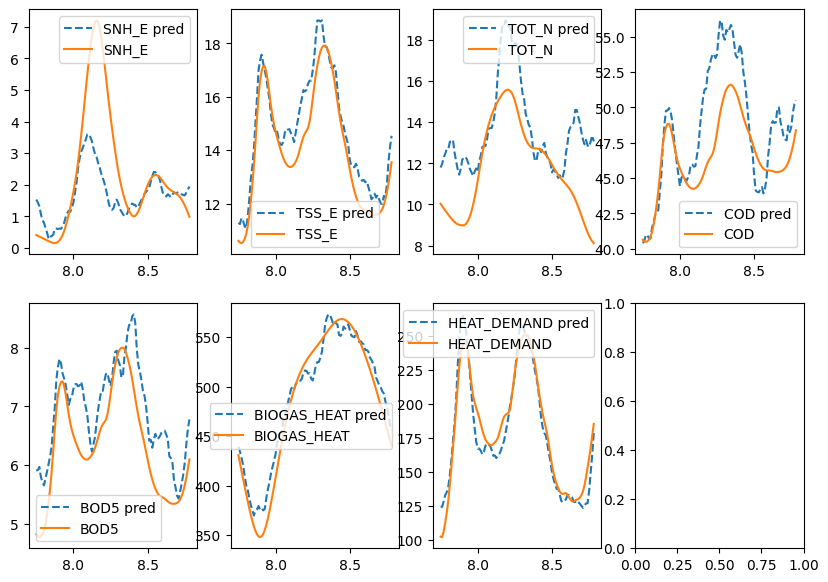

In [1]:
import gurobipy as gp
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
from torch import nn
from gurobi_ml.torch.sequential import add_sequential_constr
from gurobi_ml.sklearn.preprocessing import add_standard_scaler_constr
from gurobi_ml import add_predictor_constr, register_predictor_constr
from skorch import NeuralNetRegressor
from skorch.dataset import ValidSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
from bsm2_python.bsm2.plantperformance import PlantPerformance
import bsm2_python.bsm2.init.plantperformanceinit_bsm2 as pp_init
from bsm2_python.bsm2.init.aerationcontrolinit import KLA3GAIN, KLA5GAIN
from bsm2_python.gases.gases import GasMix
from bsm2_python.bsm2.init.reginit_bsm2 import T_OP
from bsm2_python.bsm2_ol import BSM2OL
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from nn_functions import choose_kla_4, load_scaler_and_pca, save_scaler_and_pca,transform_influent,fit_influent_scaler_and_pca


SI, SS, XI, XS, XBH, XBA, XP, SO, SNO, SNH, SND, XND, SALK, TSS, Q, TEMP, SD1, SD2, SD3, XD4, XD5 = np.arange(21)

scaler_y_in, pca_y_in = load_scaler_and_pca('scaler_pca_5_4exe.pkl')

bsm2 = BSM2OL(endtime=20)
pp = PlantPerformance(pp_init.PP_PAR)
last_steps = 144  
select = np.array([0, 60, 120])
kla_4 = 0
biogas_heat = 0
heat_demand = 0
influent = bsm2.y_in[0, :]
influent = transform_influent(influent.reshape(1, -1), scaler_y_in, pca_y_in).flatten()

effluent = np.zeros((5,))
red_dims = list(range(pca_y_in.n_components))
num_features = len((kla_4, *influent))
num_targets = len((*effluent, biogas_heat, heat_demand))
num_cols = num_features * last_steps + num_targets
features = np.zeros((bsm2.simtime.size - last_steps, num_features * last_steps))
targets = np.zeros((bsm2.simtime.size - last_steps, num_targets))
predict_targets = np.zeros_like(targets)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device {device}')


nn_regression = NeuralNetRegressor(nn.Sequential(
    nn.Linear(num_features * last_steps, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, num_targets)
),
    max_epochs=1000,
    lr=0.001,
    iterator_train__shuffle=True,
    device=device,
    optimizer=torch.optim.Adam,
    criterion=nn.MSELoss,
    batch_size=262144,
    train_split=ValidSplit(0.2),
    warm_start=True
)
nn_regression.initialize() 
nn_regression.load_params(
    f_params='model_benchmark.pkl')


with open('scaler_benchmark.pkl','rb') as f:
    std_scaler = pickle.load(f)

pipeline = make_pipeline(std_scaler, nn_regression)


bsm2.stabilize()
select = np.array([0, 60, 120, 180, 240])
kla_4 = 0
for idx, step in enumerate(tqdm(bsm2.simtime)):
    kla_4 = choose_kla_4(select, 1, kla_4)
    klas = np.array([0, 0, KLA3GAIN * kla_4, kla_4, KLA5GAIN * kla_4])
    bsm2.step(idx, klas)
    y_in = bsm2.y_in[np.where(bsm2.data_time <= step)[0][-1], :]
    y_in = transform_influent(y_in.reshape(1, -1), scaler_y_in, pca_y_in).flatten()
    curr_feature = np.concatenate((np.array([kla_4]), y_in))
    rolled_old_features = np.roll(features[idx-last_steps-1, :], -num_features)
    features[idx-last_steps, :] = rolled_old_features
    features[idx-last_steps, -num_features:] = curr_feature


    adv_eff = pp.advanced_quantities(bsm2.y_eff, components = ('totalN', 'COD', 'BOD5'))
    tot_n, cod, bod5 = adv_eff[0,:]
    effluent=np.array((bsm2.y_eff[SNH], bsm2.y_eff[TSS], tot_n, cod, bod5))
    ch4_prod, h2_prod, co2_prod, q_gas = pp.gas_production(bsm2.yd_out, T_OP, p_atm=1.0130)
    biogas = GasMix(ch4_prod, co2_prod, h2_prod)
    biogas_heat = biogas.h_u * q_gas / 24  
    heat_demand = pp.heat_demand_step(bsm2.yd_in, T_OP) 
    targets[idx-last_steps, :] = np.array((*effluent, biogas_heat, *heat_demand))

    if idx >= last_steps:
        features_shaped = features[idx-last_steps, :].astype(np.float32).reshape(1, -1)
        predict = pipeline.predict(features_shaped)
        predict_targets[idx-last_steps, :] = predict
        
# target dims are [snh, tss, tot_n, cod, bod5, biogas_heat, heat_demand]
SNH_E, TSS_E, TOT_N, COD, BOD5, BIOGAS_HEAT, HEAT_DEMAND = np.arange(7)
plot_steps = 100
plot_start = 600
fig, ax = plt.subplots(2, 4, figsize=(10, 7))
start = last_steps+plot_start
stop = last_steps+plot_start+plot_steps
for i, plot_var in enumerate(['SNH_E', 'TSS_E', 'TOT_N', 'COD', 'BOD5', 'BIOGAS_HEAT', 'HEAT_DEMAND']):
    ax[i//4, i%4].plot(bsm2.simtime[start:stop], predict_targets[start:stop, eval(plot_var)], label=plot_var+' pred', linestyle='--')
    ax[i//4, i%4].plot(bsm2.simtime[start:stop], targets[start:stop, eval(plot_var)], label=plot_var)
    ax[i//4, i%4].legend()


### Predictions on fixed dataset - for models with PCA

In [11]:
import gurobipy as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch
from torch import nn
from gurobi_ml.torch.sequential import add_sequential_constr
from gurobi_ml.sklearn.preprocessing import add_standard_scaler_constr
from gurobi_ml import add_predictor_constr, register_predictor_constr
from skorch import NeuralNetRegressor
from skorch.dataset import ValidSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
from bsm2_python.bsm2.plantperformance import PlantPerformance
import bsm2_python.bsm2.init.plantperformanceinit_bsm2 as pp_init
from bsm2_python.bsm2.init.aerationcontrolinit import KLA3GAIN, KLA5GAIN
from bsm2_python.gases.gases import GasMix
from bsm2_python.bsm2.init.reginit_bsm2 import T_OP
from bsm2_python.bsm2_ol import BSM2OL
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from nn_functions import choose_kla_4, load_scaler_and_pca, save_scaler_and_pca,transform_influent,fit_influent_scaler_and_pca


# Load test data
test_data = np.load('test_data.npz')

raw_features = test_data['features'].astype(np.float32)
raw_targets = test_data['targets'].astype(np.float32)



Using device cpu


c:\Users\AMEEN\anaconda3\envs\BSM2\lib\site-packages\skorch\net.py:2626: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f_name, map_location=map_location)
c

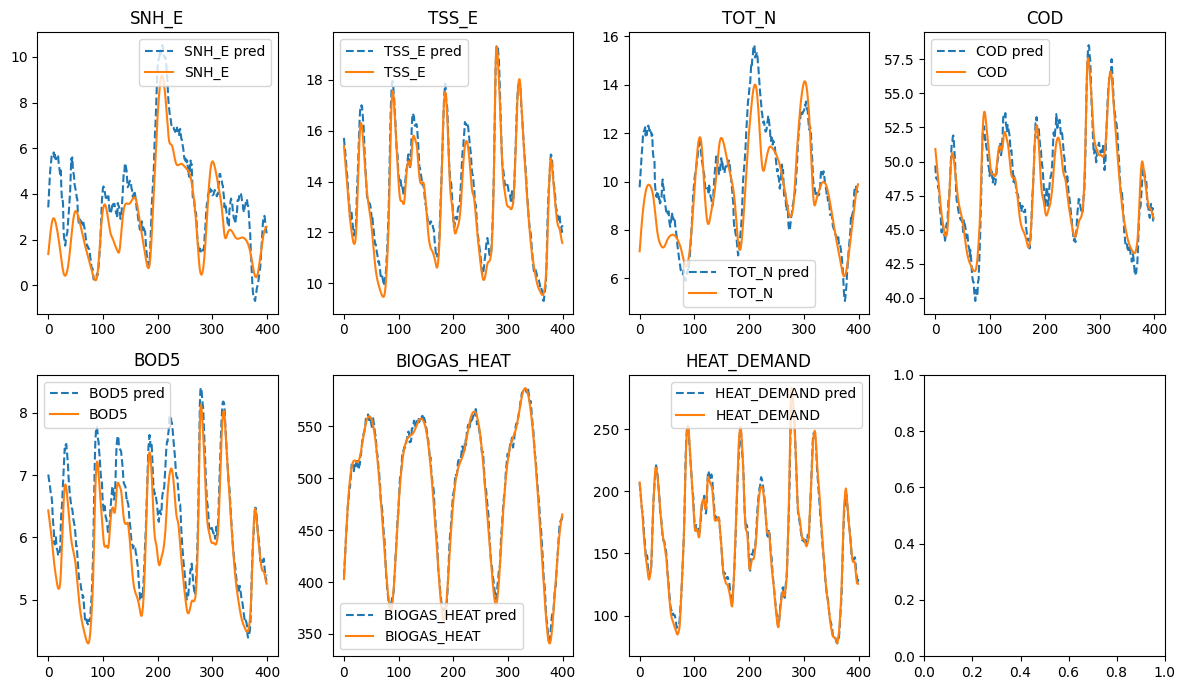

MSE: 5.568395137786865
RMSE: 2.3597447872161865
MAE: 1.4226490259170532
R^2: 0.9229550361633301
MAPE: 10.214094072580338%
Accuracy tolerance: 10.214094072580338%


In [13]:

# Load model and scaler
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device {device}')

nn_regression = NeuralNetRegressor(nn.Sequential(
    nn.Linear(raw_features.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, raw_targets.shape[1])
),
    max_epochs=5000,
    lr=0.001,
    iterator_train__shuffle=True,
    device=device,
    optimizer=torch.optim.Adam,
    criterion=nn.MSELoss,
    batch_size=128,
    train_split=None,
    warm_start=True
)
nn_regression.initialize() 
nn_regression.load_params(
    f_params=r'C:\Users\AMEEN\bsm-2-python-lin-opt\Updated Progress files\Model_parameters\nn_regression_model_latest_4exe_20000.pth')


with open(r'C:\Users\AMEEN\bsm-2-python-lin-opt\Updated Progress files\Scaler\scaler_latest_4exe_20000.pkl','rb') as f:
    std_scaler = pickle.load(f)

pipeline = make_pipeline(std_scaler, nn_regression)

# Predict using the pipeline
predict_targets = pipeline.predict(raw_features)

# Plot the true vs predicted values
SNH_E, TSS_E, TOT_N, COD, BOD5, BIOGAS_HEAT, HEAT_DEMAND = np.arange(7)
plot_steps = 400
plot_start = 0
fig, ax = plt.subplots(2, 4, figsize=(12, 7))
start = plot_start
stop = plot_start + plot_steps
target_names = ['SNH_E', 'TSS_E', 'TOT_N', 'COD', 'BOD5', 'BIOGAS_HEAT', 'HEAT_DEMAND']

for i, plot_var in enumerate(target_names):
    ax[i//4, i%4].plot(np.arange(start, stop), predict_targets[start:stop, i], label=f'{plot_var} pred', linestyle='--')
    ax[i//4, i%4].plot(np.arange(start, stop), raw_targets[start:stop, i], label=plot_var)
    ax[i//4, i%4].legend()
    ax[i//4, i%4].set_title(plot_var)

plt.tight_layout()
plt.show()

# Calculate metrics
mse = mean_squared_error(raw_targets, predict_targets)
rmse = np.sqrt(mse)
mae = mean_absolute_error(raw_targets, predict_targets)
r2 = r2_score(raw_targets, predict_targets)

# MAPE - Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(raw_targets, predict_targets)

accuracy = np.mean(np.abs(raw_targets - predict_targets) / raw_targets) * 100

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')
print(f'MAPE: {mape}%')
print(f'Accuracy tolerance: {accuracy}%')


In [3]:
# Calculate metrics
mse = mean_squared_error(raw_targets, predict_targets)
rmse = np.sqrt(mse)
mae = mean_absolute_error(raw_targets, predict_targets)
r2 = r2_score(raw_targets, predict_targets)

# MAPE - Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(raw_targets, predict_targets)

accuracy = np.mean(np.abs(raw_targets - predict_targets) / raw_targets) * 100

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')
print(f'MAPE: {mape}%')
print(f'Accuracy tolerance: {accuracy}%')


MSE: 48.33063888549805
RMSE: 6.952023983001709
MAE: 3.7831082344055176
R^2: 0.7339531779289246
MAPE: 27.580443024635315%
Accuracy tolerance: 27.580443024635315%


Using device cpu


c:\Users\AMEEN\anaconda3\envs\BSM2\lib\site-packages\skorch\net.py:2626: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f_name, map_location=map_location)
c

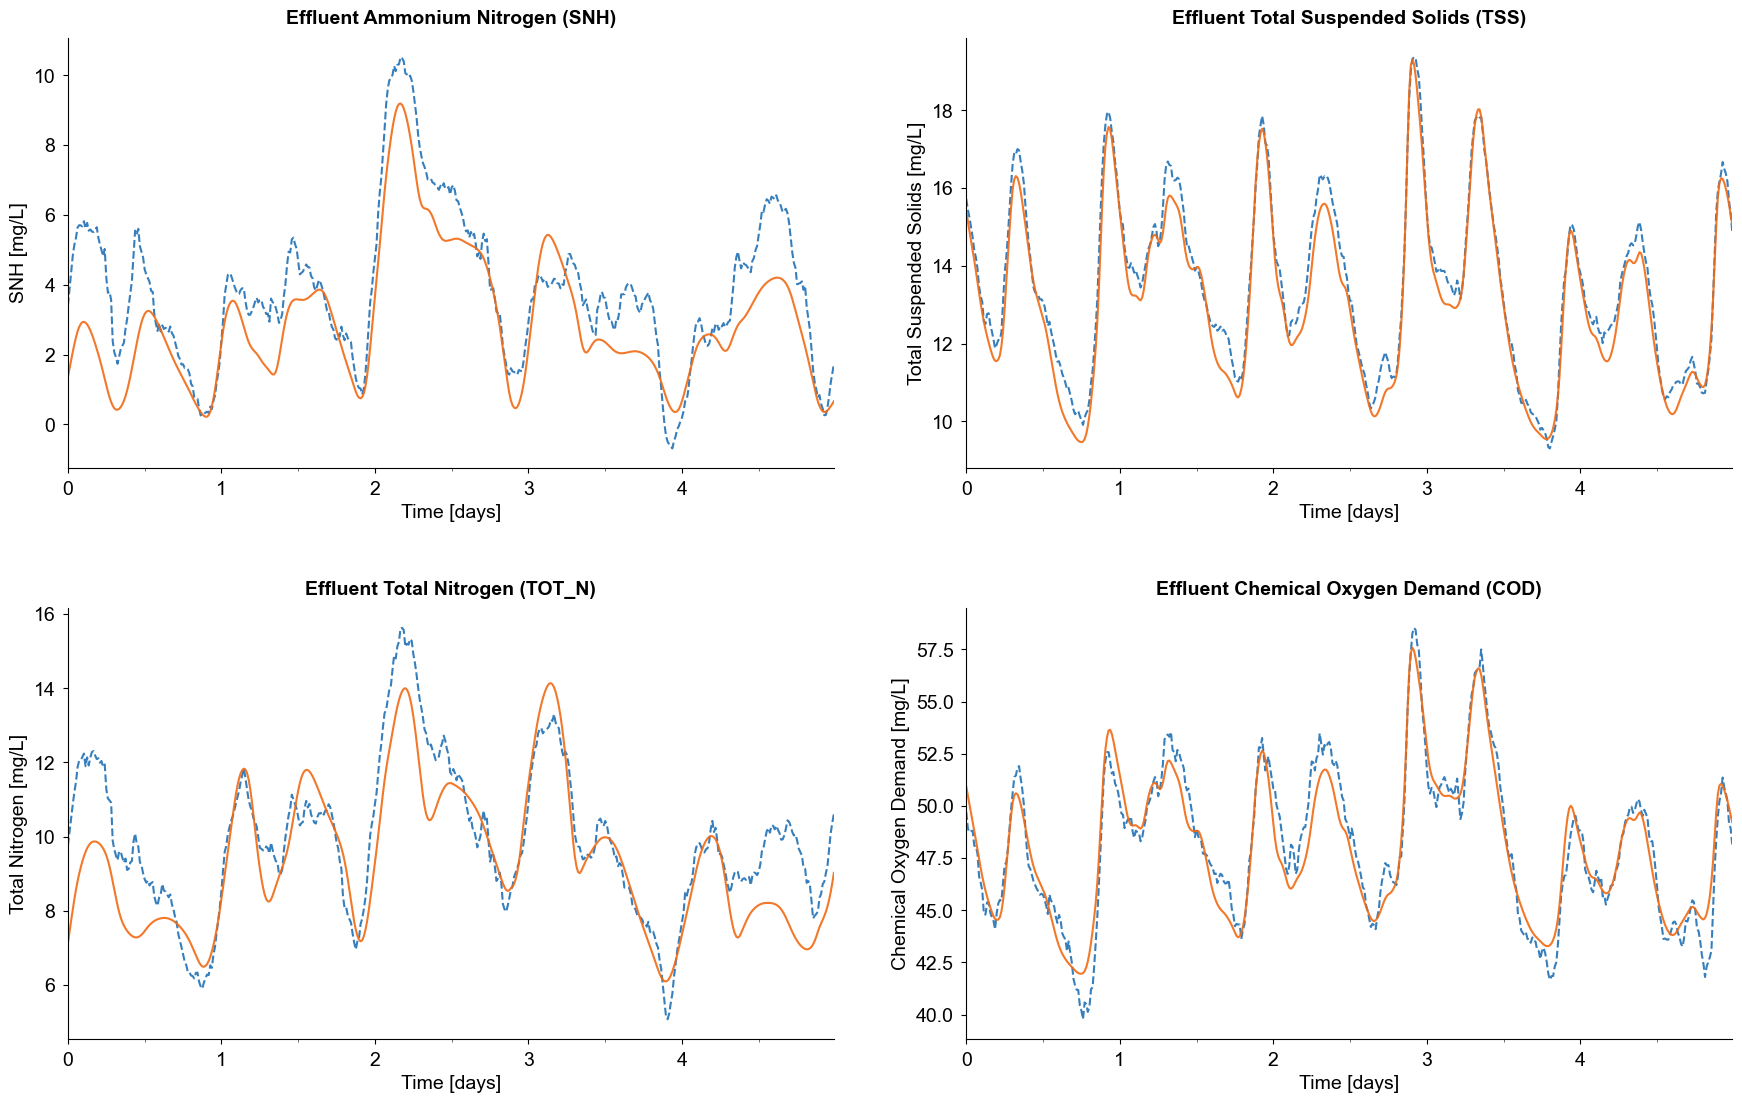

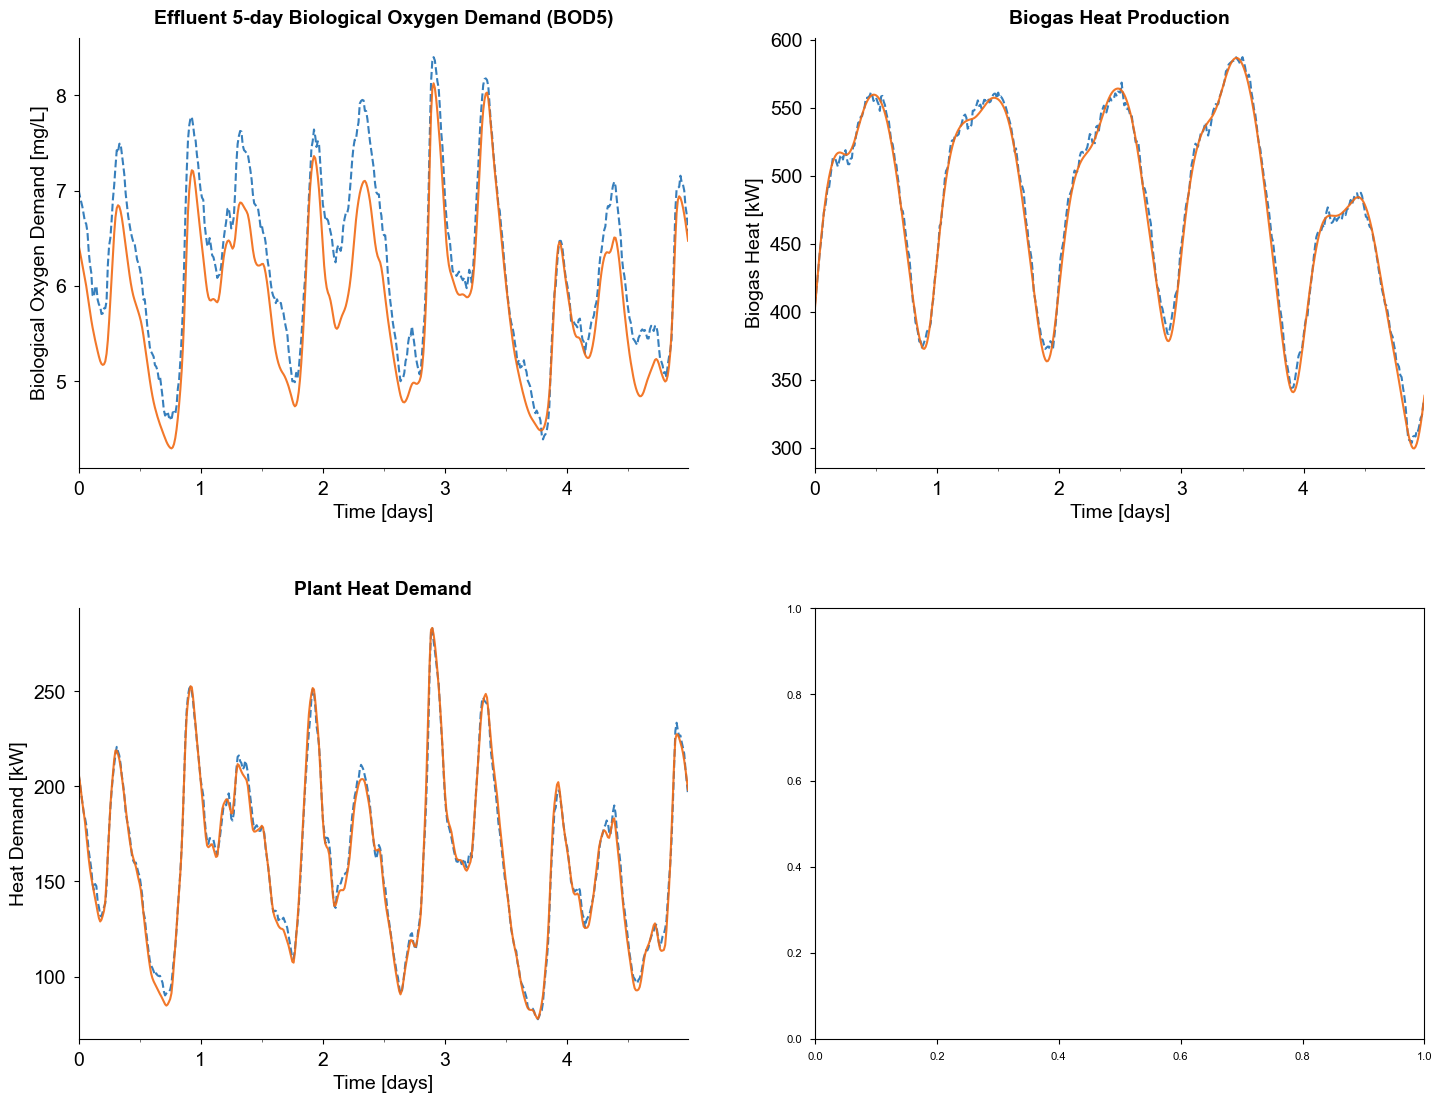

In [14]:
# Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import torch
import torch.nn as nn
import pickle
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from skorch import NeuralNetRegressor

# Load model and scaler
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device {device}')

nn_regression = NeuralNetRegressor(nn.Sequential(
    nn.Linear(raw_features.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, raw_targets.shape[1])
),
    max_epochs=18000,
    lr=0.001,
    iterator_train__shuffle=True,
    device=device,
    optimizer=torch.optim.Adam,
    criterion=nn.MSELoss,
    batch_size=128,
    train_split=None,
    warm_start=True
)
nn_regression.initialize() 
nn_regression.load_params(
    f_params=r'C:\Users\AMEEN\bsm-2-python-lin-opt\Updated Progress files\Model_parameters\nn_regression_model_latest_4exe_20000.pth')


with open(r'C:\Users\AMEEN\bsm-2-python-lin-opt\Updated Progress files\Scaler\scaler_latest_4exe_20000.pkl','rb') as f:
    std_scaler = pickle.load(f)

pipeline = make_pipeline(std_scaler, nn_regression)

# Predict using the pipeline
predict_targets = pipeline.predict(raw_features)

# Set plotting parameters
plot_steps = 480
plot_start = 0
start = plot_start
stop = plot_start + plot_steps
target_names = ['SNH', 'TSS', 'N_TOT', 'COD', 'BOD5', 'BIOGAS HEAT', 'HEAT DEMAND']


# Set the style 
plt.style.use('seaborn-v0_8-paper')
pred_color = '#41748D'  
actual_color = '#f16913'  

# Set  sizes
SMALL_SIZE = 14    
MEDIUM_SIZE = 16   
LARGE_SIZE = 30    
TITLE_SIZE = 20   

# Update font settings
plt.rc('font', size=SMALL_SIZE, family='Arial')
plt.rc('axes', titlesize=TITLE_SIZE, labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=MEDIUM_SIZE) 
plt.rc('ytick', labelsize=MEDIUM_SIZE) 
plt.rc('legend', fontsize=MEDIUM_SIZE)
# Define proper y-axis labels

y_labels = {
    'SNH': 'SNH [mg/L]',
    'TSS': 'Total Suspended Solids [mg/L]',
    'N_TOT': 'Total Nitrogen [mg/L]',
    'COD': 'Chemical Oxygen Demand [mg/L]',
    'BOD5': 'Biological Oxygen Demand [mg/L]',
    'BIOGAS HEAT': 'Biogas Heat [kW]',
    'HEAT DEMAND': 'Heat Demand [kW]'
}

# Define full titles for subplots
full_titles = {
    'SNH': 'Effluent Ammonium Nitrogen (SNH)',
    'TSS': 'Effluent Total Suspended Solids (TSS)',
    'N_TOT': 'Effluent Total Nitrogen (TOT_N)',
    'COD': 'Effluent Chemical Oxygen Demand (COD)',
    'BOD5': 'Effluent 5-day Biological Oxygen Demand (BOD5)',
    'BIOGAS HEAT': 'Biogas Heat Production',
    'HEAT DEMAND': 'Plant Heat Demand'
}



def plot_variables_split():

    
    # Calculate time in days 
    time_in_days = np.arange(start, stop) * (15/(24*60))  
    
    # First figure with 4 plots (2x2 grid)
    fig1, axes1 = plt.subplots(2, 2, figsize=(18, 12))
    axes1 = axes1.flatten()
    fig1.patch.set_facecolor('white')
    
    # Second figure with 3 plots (1x3 grid)
    fig2, axes2 = plt.subplots(2, 2, figsize=(15, 12))
    axes2 = axes2.flatten()
    fig2.patch.set_facecolor('white')
    

    def style_subplot(ax, var_idx):
        var_name = target_names[var_idx]
        
        # Plot predictions and actual values
        ax.plot(time_in_days, predict_targets[start:stop, var_idx], 
               label='Predicted',
               linestyle='--',
               color='#2171b5',
               linewidth=1.5,
               alpha=0.9)
        
        ax.plot(time_in_days, raw_targets[start:stop, var_idx], 
               label='Actual',
               color='#f16913',
               linewidth=1.5,
               alpha=0.9)
        
        # Customize subplot 
        ax.set_title(full_titles[var_name], pad=10, fontsize=14, fontweight='bold')
        ax.set_xlabel('Time [days]', fontsize=14)
        ax.set_ylabel(y_labels[var_name], fontsize=14)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=14)
        max_days = time_in_days[-1]
        ax.xaxis.set_major_locator(plt.MultipleLocator(1))  
        ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))  
        ax.set_xlim(0, max_days)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x)}'))
    # Plot first 4 variables
    for i in range(4):
        style_subplot(axes1[i], i)
    fig1.suptitle('', 
                 fontsize=18, fontweight='bold', y=0.95)
    fig1.tight_layout(pad=2.0, h_pad=3.0, w_pad=3.0)
    for i in range(3):
        style_subplot(axes2[i], i+4)
    fig2.suptitle('', 
                 fontsize=18, fontweight='bold', y=1.05)
    fig2.tight_layout(pad=2.0, h_pad=3.0, w_pad=3.0)
    

    
    plt.show()


# Set the style
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plot_variables_split()



In [15]:
def calculate_metrics(y_true, y_pred):
    """Calculate all regression metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    # Calculate MAPE avoiding division by zero
    mape = np.mean(np.abs((y_true - y_pred) / y_true) * 100)
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape
    }

# Calculate metrics for each target
results = {}
for i, target in enumerate(target_names):
    y_true = raw_targets[:, i]
    y_pred = predict_targets[:, i]
    results[target] = calculate_metrics(y_true, y_pred)

# Print results in a formatted table
print("\nPerformance Metrics for Each Parameter:")
print("-" * 100)
print(f"{'Parameter':<15} {'MSE':>15} {'RMSE':>15} {'MAE':>15} {'R²':>15} {'MAPE':>15}")
print("-" * 100)

for target, metrics in results.items():
    print(f"{target:<15} {metrics['MSE']:>15.4f} {metrics['RMSE']:>15.4f} "
          f"{metrics['MAE']:>15.4f} {metrics['R²']:>15.4f} {metrics['MAPE']:>15.4f}")
print("-" * 100)


Performance Metrics for Each Parameter:
----------------------------------------------------------------------------------------------------
Parameter                   MSE            RMSE             MAE              R²            MAPE
----------------------------------------------------------------------------------------------------
SNH                      1.7717          1.3311          1.0273          0.8378         50.5515
TSS                      0.1516          0.3894          0.3027          0.9853          2.1665
N_TOT                    2.0462          1.4305          1.1351          0.7304         11.2939
COD                      1.1935          1.0925          0.8503          0.9383          1.7699
BOD5                     0.0679          0.2606          0.2018          0.9751          3.1820
BIOGAS HEAT             21.1002          4.5935          3.6321          0.9960          0.8032
HEAT DEMAND             12.6479          3.5564          2.8092          0.9977      